In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import gpustat
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn
from torchvision.io import read_image
import torchvision.transforms as transforms

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [4]:
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)
print(stats)

GPUStatCollection(host=poppy, [
  [0] NVIDIA A100 80GB PCIe | 34°C,   0 % |  1288 / 81920 MB | murillor(1286M)
  [1] NVIDIA A100 80GB PCIe | 27°C,   0 % |     2 / 81920 MB |
  [2] NVIDIA A100 80GB PCIe | 55°C,  86 % | 80236 / 81920 MB | murillor(1286M) chriscs(78948M)
])


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
base_folder = "spatial_sim_data"
labels = pd.read_csv(base_folder + "/labels.csv", names = ["path", "N", "n", "nPO"])
print(labels)

                                        path      N    n  nPO
0      images/spatial_sim_parents_1000_0_500   1011  500  127
1      images/spatial_sim_parents_1000_1_500   1017  500  120
2      images/spatial_sim_parents_1000_2_500   1027  500  114
3      images/spatial_sim_parents_1000_3_500   1024  500  119
4      images/spatial_sim_parents_1000_4_500   1009  500  113
...                                      ...    ...  ...  ...
2515  images/spatial_sim_parents_9900_23_500   9958  500   10
2516  images/spatial_sim_parents_9900_24_500  10030  500   15
2517  images/spatial_sim_parents_9900_25_500   9958  500   12
2518  images/spatial_sim_parents_9900_26_500  10033  500    9
2519  images/spatial_sim_parents_9900_27_500  10041  500   11

[2520 rows x 4 columns]


In [7]:
idx = 0
base_path = base_folder + "/" + labels['path'].iloc[0]
spaghetti_path = base_path + "_spaghetti.png"
samples_path = base_path + "_samples.png"
print(spaghetti_path)
print(samples_path)
spaghetti = read_image(spaghetti_path)
samples = read_image(samples_path)

spatial_sim_data/images/spatial_sim_parents_1000_0_500_spaghetti.png
spatial_sim_data/images/spatial_sim_parents_1000_0_500_samples.png


In [8]:
print(spaghetti.size())
print(samples.size())
# Number of samples, should be 500
print(samples.sum()/255)
images = torch.cat((spaghetti, samples), 0)
print(images.size())

torch.Size([1, 500, 500])
torch.Size([1, 500, 500])
tensor(499.)
torch.Size([2, 500, 500])


In [22]:
class KinDataset(Dataset):
    def __init__(self, base_folder, labels_file):
        self.labels = pd.read_csv(base_folder + "/" + labels_file, names = ["path", "N", "n", "nPO"])
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        base_path = self.base_folder + "/" + self.labels['path'].iloc[idx]
        spaghetti_path = base_path + "_spaghetti.png"
        samples_path = base_path + "_samples.png"
        spaghetti = read_image(spaghetti_path)
        samples = read_image(samples_path)
        input_tensor = torch.cat((spaghetti, samples), 0).float()
        label = torch.tensor([self.labels['N'].iloc[idx]]).float()
        return input_tensor, label
    
kin_dataset = KinDataset("spatial_sim_data", "labels.csv")

In [23]:
print(kin_dataset[2][0].size())
print(kin_dataset[2][1])
print(kin_dataset[100][1])

torch.Size([2, 500, 500])
tensor([1027.])
tensor([1319.])


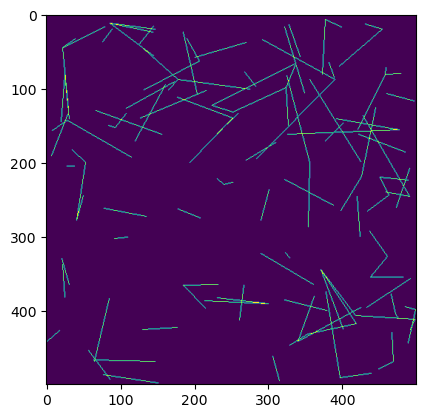

In [24]:
plt.imshow(kin_dataset[2][0][0])

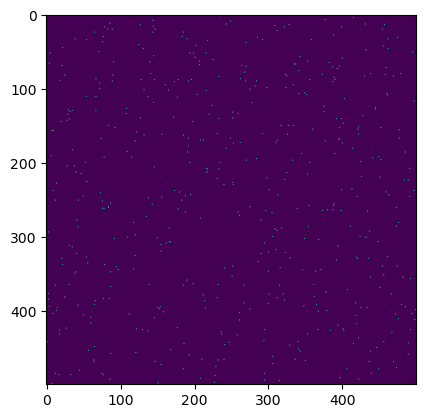

In [12]:
plt.imshow(kin_dataset[2][0][1])

In [13]:
n_total = len(kin_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [14]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

1260
630
630


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = Net()
model = model.to(device) 

In [16]:
loss_fn = nn.MSELoss(reduction='mean')

In [17]:
print((3035-0.148)**2)

9210326.661904


In [18]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

In [25]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

Epoch 1 loss: 16766579.5619 val_loss: 11931466.2381
Epoch 2 loss: 8450473.3841 val_loss: 7297841.4825
Epoch 3 loss: 3659169.4937 val_loss: 2756159.9341
Epoch 4 loss: 1329742.9460 val_loss: 1668611.0984
Epoch 5 loss: 755112.9679 val_loss: 1591824.9230
Epoch 6 loss: 526949.9857 val_loss: 1464392.0468
Epoch 7 loss: 353511.3573 val_loss: 1546463.1675
Epoch 8 loss: 259742.4161 val_loss: 1491621.0841
Epoch 9 loss: 192560.2480 val_loss: 1777602.2750
Epoch 10 loss: 140263.0586 val_loss: 1618292.2552
Epoch 11 loss: 87884.0854 val_loss: 1564024.1813
Epoch 12 loss: 63315.9125 val_loss: 1562531.1726
Epoch 13 loss: 55699.1011 val_loss: 1578012.2250
Epoch 14 loss: 45001.5737 val_loss: 1595432.7611
Epoch 15 loss: 45462.7042 val_loss: 1602071.0198
Epoch 16 loss: 45272.9088 val_loss: 1599632.1913
Epoch 17 loss: 40385.5835 val_loss: 1597124.0766
Epoch 18 loss: 48780.2857 val_loss: 1604750.0944
Epoch 19 loss: 43362.3562 val_loss: 1637660.2821
Epoch 20 loss: 45106.8966 val_loss: 1715495.7135


In [27]:
#Save model
PATH = "first_model.pt"
torch.save(model.state_dict(), PATH)

In [19]:
# Load model
PATH = "first_model.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

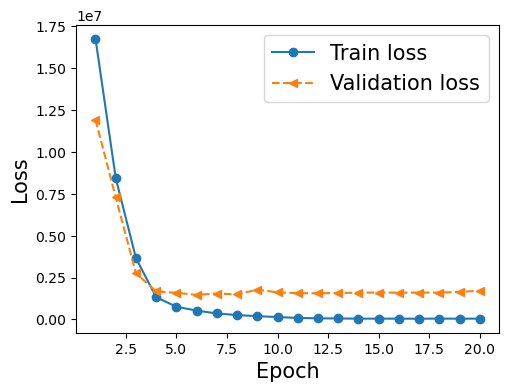

In [28]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [20]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        #test_pred[i] = test_output.numpy()
        #test_truth[i] = test_output[0].numpy()
        #test_pred[i] = model(test_input)[0, 0].numpy()

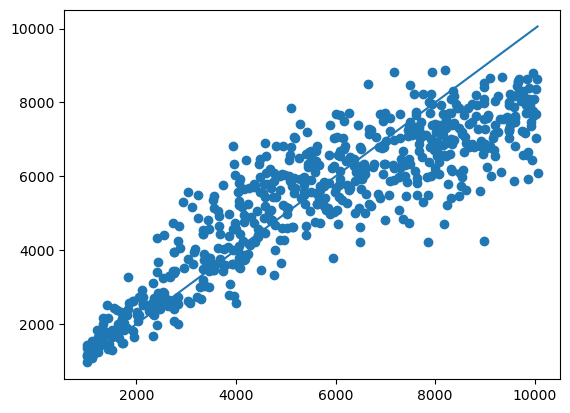

In [21]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

1260
630
630


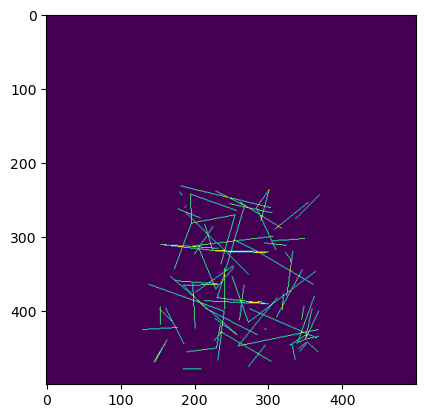

In [26]:
# Train on spatially biased sampling
bias_dataset = KinDataset("spatial_sim_data", "labels_bias.csv")
plt.imshow(bias_dataset[2][0][0])
n_total = len(bias_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid
train_bias, valid_bias, test_bias = random_split(bias_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))
batch_size = 64
train_bias_dl = DataLoader(train_bias, batch_size, shuffle = True)
valid_bias_dl = DataLoader(valid_bias, batch_size, shuffle = True)
test_bias_dl = DataLoader(test_bias, batch_size, shuffle = True)
print(len(train_bias))
print(len(valid_bias))
print(len(test_bias))

In [27]:
model_bias = Net()
model_bias = model_bias.to(device) 

In [28]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_bias.parameters(), lr=0.0001)
torch.manual_seed(1)
num_epochs = 20
hist = train(model_bias, num_epochs, train_bias_dl, valid_bias_dl)

Epoch 1 loss: 15468056.0825 val_loss: 10293108.0079
Epoch 2 loss: 7362392.2286 val_loss: 6406288.9794
Epoch 3 loss: 3367309.7992 val_loss: 2495635.0056
Epoch 4 loss: 1092806.5032 val_loss: 1193139.0440
Epoch 5 loss: 643869.9091 val_loss: 1026402.5107
Epoch 6 loss: 461843.0305 val_loss: 1000322.9151
Epoch 7 loss: 367774.2934 val_loss: 908624.9272
Epoch 8 loss: 316446.1001 val_loss: 931410.9905
Epoch 9 loss: 242724.9764 val_loss: 910783.4687
Epoch 10 loss: 192560.0992 val_loss: 1003178.5496
Epoch 11 loss: 168983.5494 val_loss: 921876.1343
Epoch 12 loss: 148122.4691 val_loss: 976416.0940
Epoch 13 loss: 124300.7541 val_loss: 904469.4089
Epoch 14 loss: 98734.5290 val_loss: 968975.3260
Epoch 15 loss: 81171.4464 val_loss: 947262.5573
Epoch 16 loss: 64886.8747 val_loss: 947585.8730
Epoch 17 loss: 59740.9265 val_loss: 957292.1369
Epoch 18 loss: 52701.8770 val_loss: 952787.6177
Epoch 19 loss: 52833.4531 val_loss: 974471.5032
Epoch 20 loss: 44215.9733 val_loss: 1006545.6595


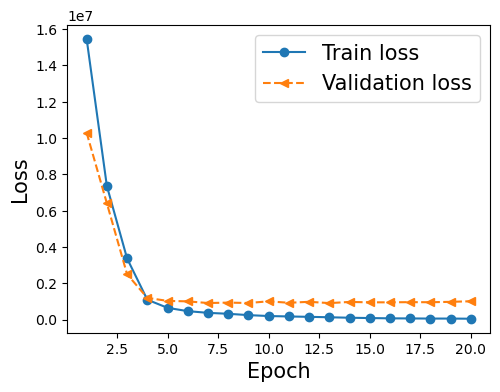

In [29]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [30]:
#Save model
PATH = "bias_model.pt"
torch.save(model_bias.state_dict(), PATH)

In [ ]:
# Load model
PATH = "model_bias.pt"
model_bias = Net()
model_bias.load_state_dict(torch.load(PATH))
model_bias.eval()

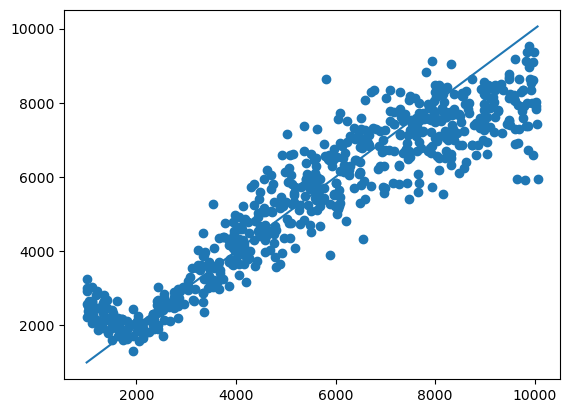

In [32]:
torch.cuda.synchronize()
model_cpu = model_bias.cpu()

test_truth = np.empty(len(test_bias))
test_pred = np.empty(len(test_bias))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_bias):
        test_pred[i] = model_bias(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

It probably has the weird pattern under 2000 because the sample size is smaller for those populations.

In [33]:
# Train on just the spaghetti plots and see if it does just as well (it should)
class KinOnlyDataset(Dataset):
    def __init__(self, base_folder):
        self.labels = pd.read_csv(base_folder + "/labels.csv", names = ["path", "N", "n", "nPO"])
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        base_path = self.base_folder + "/" + self.labels['path'].iloc[idx]
        spaghetti_path = base_path + "_spaghetti.png"
        spaghetti = read_image(spaghetti_path)
        input_tensor = spaghetti.float()
        label = torch.tensor([self.labels['N'].iloc[idx]]).float()
        return input_tensor, label
    
kin_only_dataset = KinOnlyDataset("spatial_sim_data")

In [ ]:
n_total = len(kin_only_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [ ]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

1260
630
630


tensor([[1.8642]], grad_fn=<AddmmBackward0>)
tensor([5373.])


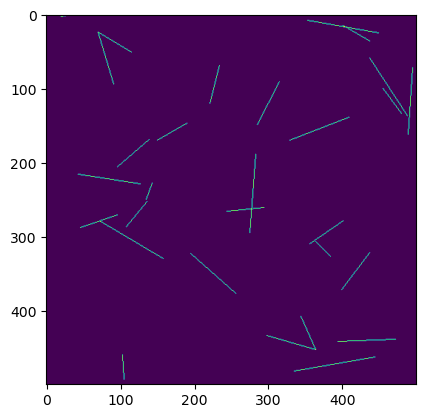

In [46]:
i = 1000
print(net(train_kin[i][0].unsqueeze(0)))
print(train_kin[i][1])
plt.imshow(train_kin[i][0][0])

In [ ]:
model_cpu = model.cpu()
i = 0
with(torch.no_grad()):
    pred = model_cpu(train_kin[i][0].unsqueeze(0))
truth = train_kin[i][1]
print(pred)
print(truth)
print(loss_fn(pred[0], truth))

tensor([[0.1483]])
tensor([3035.])
tensor(9210325.)


In [ ]:
x_batch, y_batch = next(iter(train_kin_dl))

In [ ]:
print(x_batch[0])

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
